In [1]:
# !pip install finance-datareader
# !pip install plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

import torch
import torch.nn as nn

In [3]:
data = fdr.DataReader("005930")
data = data[["Close"]]
data

,Close
Date,
2000-04-21,6050
2000-04-24,5800
2000-04-25,5640
2000-04-26,5600
2000-04-27,5400
...,...
2024-08-05,71400
2024-08-06,72500
2024-08-07,74700


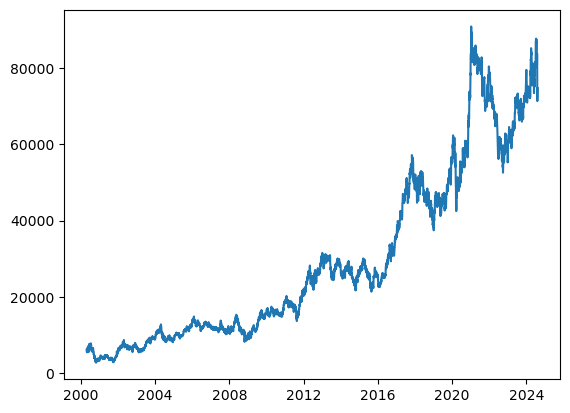

In [4]:
plt.plot(data)

## 딥러닝 전용으로 코드 작성
- Close의 추세를 반영해서 Close값 예측

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-05-03,6180,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0,6050.0
2000-05-04,6180,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0
2000-05-08,6560,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0
2000-05-09,6370,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0
2000-05-10,6350,6370.0,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0
...,...,...,...,...,...,...,...,...
2024-08-05,71400,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0,80400.0
2024-08-06,72500,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0
2024-08-07,74700,72500.0,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0


In [6]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np.shape

(5993, 8)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [8]:
X = shifted_df_as_np[:,1:] 
y = shifted_df_as_np[:,0]
print(X.shape, y.shape)

(5993, 7) (5993,)


In [9]:
X[0]

array([-0.91956497, -0.92590914, -0.9395038 , -0.93497224, -0.93406593,
       -0.93044069, -0.92477625])

In [10]:
X = dc(np.flip(X,axis=1))

In [11]:
split_index = int(len(X)*0.95)
split_index

5693

## Train and Test

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [13]:
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)

(5693, 7, 1) (300, 7, 1) (5693, 1) (300, 1)


In [14]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [15]:
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)

torch.Size([5693, 7, 1]) torch.Size([300, 7, 1]) torch.Size([5693, 1]) torch.Size([300, 1])


In [18]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)